In [1]:
import os, glob, re, numpy as np, geopandas as gpd, rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

SHAPEFILE = "../data/raw/city boundaries/citygcs_regional_mun_wgs84.shp"         
LST_GLOB  = "../data/raw/lst/daytime lst/MOD11A1.061_LST_Day_1km_2024-*.tif"
QC_GLOB   = "../data/raw/lst/quality control layer/MOD11A1.061_QC_Day_2024-*.tif"
OUT_DIR   = "../data/processed/lst_clean"
OUT_SINU  = f"{OUT_DIR}/lst_summer_2024_mean_sinusoidal.tif"
OUT_WGS84 = f"{OUT_DIR}/lst_summer_2024_mean_wgs84.tif"
OUT_VALID = f"{OUT_DIR}/lst_summer_2024_valid_count.tif"
EXPORT_WGS84 = True

os.makedirs(OUT_DIR, exist_ok = True)

date_re = re.compile(r"(\d{4}-\d{2}-\d{2})")

def sort_by_date(file_list):
    matches = {}
    for file_path in sorted(glob.glob(file_list)):
        match = date_re.search(file_path)
        if match:
            matches[match.group(1)] = file_path
    return matches

lst_by_date = sort_by_date(LST_GLOB)
qc_by_date  = sort_by_date(QC_GLOB)

if not lst_by_date:
    raise FileNotFoundError("No LST files found.")
if not qc_by_date:
    raise FileNotFoundError("⚠️ No QC files found; proceeding without QA masking.")

dates = sorted(set(lst_by_date.keys()) & set(qc_by_date.keys()))
print("Processing dates (have BOTH LST and QC):", dates)
if not dates:
    raise RuntimeError("No overlapping dates between LST and QC; check filenames.")

with rasterio.open(lst_by_date[dates[0]]) as src0:
    r_crs = src0.crs
city = gpd.read_file(SHAPEFILE).to_crs(r_crs)

# little endian encoding -- 8 bits convey information re: data quality, emissivity error, and LST error 
def soft_qc_mask(qc_arr):
    qc = qc_arr.astype("uint8")
    mandatory = (qc & 0b11) # bits 0-1 (qa) {10, 11 --> data not produced}
    lst_err   = (qc >> 6) & 0b11 # bits 6-7 (LST error) {10, 11 <= 3K}
    ok_mand   = (mandatory == 0) | (mandatory == 1)
    ok_lster  = (lst_err == 0) | (lst_err == 1)
    return ok_mand & ok_lster # keeps pixels with bits 0-1 in {00, 01} and LST error in {00, 01}

Processing dates (have BOTH LST and QC): ['2024-06-01', '2024-06-04', '2024-06-06', '2024-06-07', '2024-06-12', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-20', '2024-06-22', '2024-06-24', '2024-06-27', '2024-06-28', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-11', '2024-07-12', '2024-07-13', '2024-07-14', '2024-07-17', '2024-07-18', '2024-07-19', '2024-07-20', '2024-07-22', '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29', '2024-07-31', '2024-08-04', '2024-08-07', '2024-08-10', '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-20', '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24', '2024-08-25', '2024-08-26', '2024-08-27', '2024-08-29', '2024-08-30', '2024-08-31']


C:\Users\vedan\AppData\Local\Temp\ipykernel_29492\2181465020.py:33: RuntimeWarning: Mean of empty slice
  summer_mean = np.nanmean(stack, axis = 0).astype("float32")


✅ Saved: ../data/processed/lst_clean/lst_summer_2024_mean_sinusoidal.tif
✅ Saved: ../data/processed/lst_clean/lst_summer_2024_valid_count.tif (per-pixel # of valid LST days)
🌍 Saved: ../data/processed/lst_clean/lst_summer_2024_mean_wgs84.tif


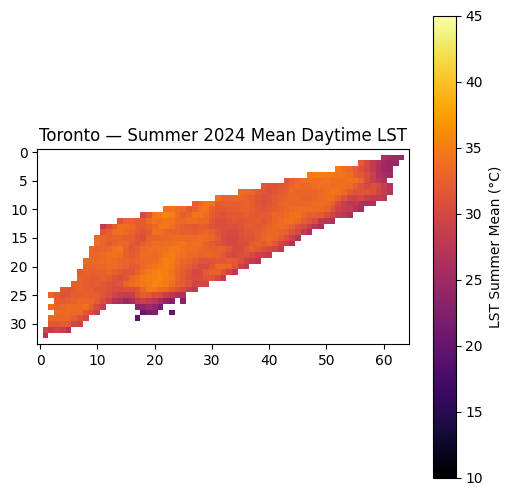

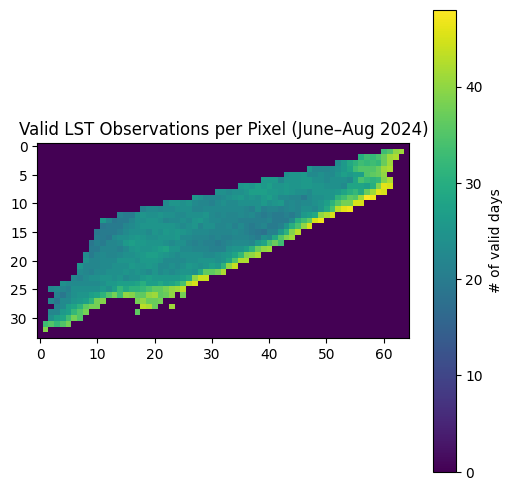

In [2]:
stack = []
valid_count = None
transform_ref = None
meta_ref = None

for date in dates:
    lst_fp = lst_by_date[date]
    qc_fp  = qc_by_date[date]
    with rasterio.open(lst_fp) as src, rasterio.open(qc_fp) as qsrc:
        lst_clip,  lst_transform  = mask(src,  city.geometry, crop=True, nodata=src.nodata)
        qc_clip,   _              = mask(qsrc, city.geometry, crop=True, nodata=qsrc.nodata)
        lst = lst_clip[0].astype("float32")
        qc  = qc_clip[0].astype("uint8")

        # Fill handing, set to 0.
        lst[lst == 0] = np.nan

        # Temperature conversion; Kelvin, then Celsius
        lst = (lst * 0.02) - 273.15

        mask_good = soft_qc_mask(qc)
        lst = np.where(mask_good, lst, np.nan)

        stack.append(lst)
        vc = np.isfinite(lst).astype("uint16")
        valid_count = vc if valid_count is None else (valid_count + vc)

        if transform_ref is None:
            transform_ref = lst_transform
            meta_ref = src.meta.copy()

stack = np.array(stack)
summer_mean = np.nanmean(stack, axis = 0).astype("float32")

# save sindusoidal data (science-grade outputs)
meta_out = meta_ref.copy()
meta_out.update({
    "height": summer_mean.shape[0],
    "width":  summer_mean.shape[1],
    "transform": transform_ref,
    "dtype": "float32",
    "count": 1,
    "crs": r_crs,
    "nodata": np.nan,
})
with rasterio.open(OUT_SINU, "w", **meta_out) as dst:
    dst.write(summer_mean, 1)

meta_vc = meta_out.copy()
meta_vc.update({"dtype": "uint16", "nodata": 0})
with rasterio.open(OUT_VALID, "w", **meta_vc) as dst:
    dst.write(valid_count, 1)

print(f"✅ Saved: {OUT_SINU}")
print(f"✅ Saved: {OUT_VALID} (per-pixel # of valid LST days)")

# Build copy in WGS84 projection for mappin
if EXPORT_WGS84:
    with rasterio.open(OUT_SINU) as src:
        dst_crs = "EPSG:4326"
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        meta_wgs = src.meta.copy()
        meta_wgs.update({
            "crs": dst_crs, "transform": transform,
            "width": width, "height": height,
            "dtype": "float32", "nodata": np.nan
        })
        with rasterio.open(OUT_WGS84, "w", **meta_wgs) as dst:
            reproject(
                source = rasterio.band(src, 1),
                destination = rasterio.band(dst, 1),
                src_transform = src.transform, src_crs = src.crs,
                dst_transform = transform,  dst_crs = dst_crs,
                resampling = Resampling.bilinear
            )
    print(f"🌍 Saved: {OUT_WGS84}")
    

# sanity check - show plots
fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(summer_mean, vmin = 10, vmax = 45, cmap = "inferno")
plt.colorbar(im, ax = ax, label = "LST Summer Mean (°C)")
ax.set_title("Toronto — Summer 2024 Mean Daytime LST")
plt.show()

fig, ax = plt.subplots(figsize = (6,6))
im = ax.imshow(valid_count, cmap = "viridis")
plt.colorbar(im, ax = ax, label = "# of valid days")
ax.set_title("Valid LST Observations per Pixel (June–Aug 2024)")
plt.show()